# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
import pickle as pkl
import seaborn as sns
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support

In [3]:
from backend import data_paths
from backend import evaluation_utils
from backend import gauge_groups_utils
from backend import loading_utils
from backend import metrics_utils
from backend import skill_prediction_utils

# Load Basin Attributes for Latitude & Longitude

In [4]:
gauges = gauge_groups_utils.get_full_gauge_group()
print(f'There are {len(gauges)} gauges.')

There are 5678 gauges.


In [5]:
attributes = loading_utils.load_attributes_file(gauges=gauges)

# Load Return Period Metrics

In [6]:
_DATASET_RETURN_PERIOD_METRICS_PATH = {
    'google_2014': data_paths.GOOGLE_2014_RETURN_PERIOD_METRICS_DIR,
    'google_1980': data_paths.GOOGLE_1980_RETURN_PERIOD_METRICS_DIR,
    'glofas_2014': data_paths.GLOFAS_2014_RETURN_PERIOD_METRICS_DIR,
    'glofas_1980': data_paths.GLOFAS_1980_RETURN_PERIOD_METRICS_DIR,
}

In [7]:
precisions_by_lead_time = {}
recalls_by_lead_time = {}

precisions_by_return_period = {}
recalls_by_return_period = {}

for dataset, data_path in _DATASET_RETURN_PERIOD_METRICS_PATH.items():
    print(f'Working on {dataset} ...')
    file_path = data_paths.CONCATENATED_RETURN_PERIOD_DICTS_DIR / f'{dataset}_return_period_dicts.pkl'
    with open(file_path, 'rb') as f:
        precisions_by_lead_time[dataset], recalls_by_lead_time[dataset] = pkl.load(f)
    print(f'Finished loading {dataset}. \n')

Working on google_2014 ...
Finished loading google_2014. 

Working on google_1980 ...
Finished loading google_1980. 

Working on glofas_2014 ...
Finished loading glofas_2014. 

Working on glofas_1980 ...
Finished loading glofas_1980. 



# Calculate F1 Scores from Precision & Recall

In [8]:
f1s_by_lead_time = {
    dataset: {
        experiment: {
            lead_time:
              evaluation_utils.f1_from_precision_and_recall_dfs(
                  precision_df=precisions_by_lead_time[dataset][experiment][lead_time],
                  recall_df=recalls_by_lead_time[dataset][experiment][lead_time]
              ) for lead_time in data_paths.LEAD_TIMES
        } for experiment in precisions_by_lead_time[dataset]
    } for dataset in _DATASET_RETURN_PERIOD_METRICS_PATH
}

# Skill Predictability

## Extract Basin Attributes as Classifier/Regression Inputs

In [9]:
# A subset of attributes to use as predictor values. This selection is mostly
# due to challenges in naming all the HydroATLAS variables, and the skill
# is not affected by removing some of the landcover class variables.
ATTRIBUTE_DESCRIPTIVE_NAMES = {
    'calculated_drain_area': 'Drain Area',
    'inu_pc_umn': 'Inundation Percent Min',
    'inu_pc_umx': 'Inundation Percent Max',
    # 'inu_pc_ult': 'Inundation Percent Long Term Maximum',
    'lka_pc_use': 'Precent Lake Area',
    'lkv_mc_usu': 'Lake Volume',
    'rev_mc_usu': 'Reservoir Volume',
    'ria_ha_usu': 'River Area',
    'riv_tc_usu': 'River Volume',
    'ele_mt_uav': 'Elevation',
    'slp_dg_uav': 'Slope',
    'tmp_dc_uyr': 'Air Temperature',
    'pre_mm_uyr': 'Precipitation',
    'pet_mm_uyr': 'PET',
    'aet_mm_uyr': 'AET',
    'ari_ix_uav': 'Aridity Index',
    'cmi_ix_uyr': 'Climate Moisture Index',
    'snw_pc_uyr': 'Snow Cover Extent',
    'for_pc_use': 'Forest Cover Extent',
    'crp_pc_use': 'Cropland Extent',
    'pst_pc_use': 'Pastiure Extent',
    'ire_pc_use': 'Irrigated Area Extent',
    'gla_pc_use': 'Glacier Extent',
    'prm_pc_use': 'Permafrost Extent',
    'pac_pc_use': 'Protected Area Extent',
    'cly_pc_uav': 'Soil Clay Fraction',
    'slt_pc_uav': 'Soil Silt Fraction',
    'snd_pc_uav': 'Soil Sand Fraction',
    'soc_th_uav': 'Soil Organic Carbon',
    'swc_pc_uyr': 'Soil Water Content',
    'kar_pc_use': 'Karst Area Extent',
    'ero_kh_uav': 'Soil Erosion',
    'pop_ct_usu': 'Population Count',
    'ppd_pk_uav': 'Population Density',
    'urb_pc_use': 'Urban Area Extent',
    'nli_ix_uav': 'Nighttime Lights Index',
    # 'rdd_mk_uav': 'Road Density',
    # 'hft_ix_u93': 'Human Footprint 1993',
    # 'hft_ix_u09': 'Human Footprint 2009',
    'gdp_ud_usu': 'GDP',
    # 'latitude': 'latitude',
    # 'longitude': 'longitude',
}

# Select the subset of attributes.
regression_attributes = attributes[ATTRIBUTE_DESCRIPTIVE_NAMES.keys()]
regression_attributes.rename(columns=ATTRIBUTE_DESCRIPTIVE_NAMES, inplace=True)

# Normalize the attributes.
regression_attributes = (regression_attributes - regression_attributes.mean()) / regression_attributes.std()

/tmp/ipykernel_389976/1900861654.py:51: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  regression_attributes.rename(columns=ATTRIBUTE_DESCRIPTIVE_NAMES, inplace=True)


## Hyperparameters for Reliability Score Predictions

In [10]:
# Hyperparamters for reliability score predictions.
lead_time = 0
return_period = 5
metric='F1 Score'

# Feature Importances

There are 36 predictors.
There are 3457 samples.


/home/gsnearing/github_repo/global_streamflow_model_paper/notebooks/backend/skill_prediction_utils.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(


There are 36 predictors.
There are 4699 samples.


/home/gsnearing/github_repo/global_streamflow_model_paper/notebooks/backend/skill_prediction_utils.py:164: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(


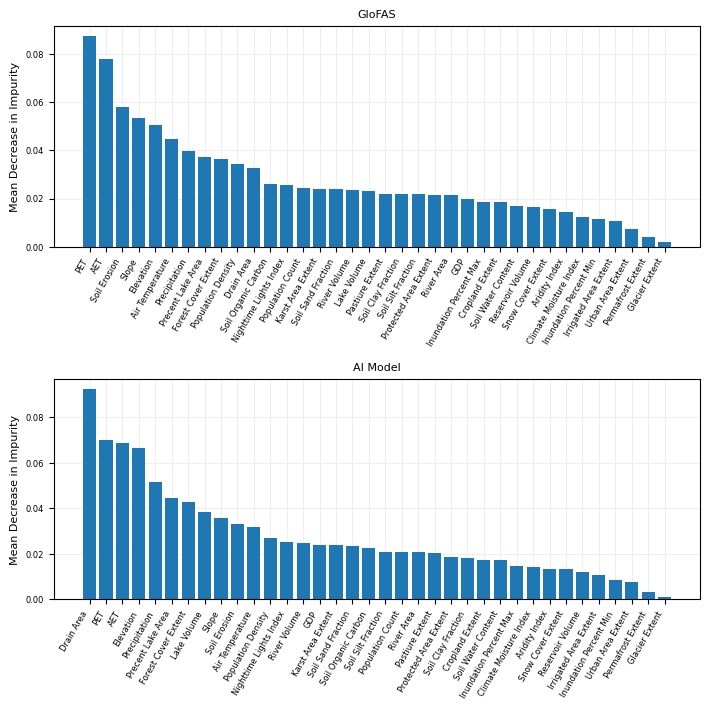

In [11]:
fig, axes = plt.subplots(
    2, 1, 
    figsize=(
        evaluation_utils.NATURE_FIG_SIZES['two_column'],
        evaluation_utils.NATURE_FIG_SIZES['two_column'],
    )
)

# --- GloFAS --------------------------------
regression_data = f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
    lead_time][return_period].dropna().rename(metric)
experiment = metrics_utils.GLOFAS_VARIABLE
bins = None #[-0.1, regression_data.mean(), 1.01]

x, y = skill_prediction_utils.make_predictors(
    x=regression_attributes,
    y=regression_data,
    metric=metric,
    bins=bins
)

glofas_importances, _ = y_hat = skill_prediction_utils.feature_importances(
    x, y,
    # classifier=True
    regression=True
)

skill_prediction_utils.plot_feature_importances(
    importances=glofas_importances,
    ax=axes[0]
)
axes[0].set_title(
    evaluation_utils.EXPERIMENT_NAMES[experiment],
    fontsize=evaluation_utils.NATURE_FONT_SIZES['title']
)

# --- Google Model ----------------------------
regression_data = f1s_by_lead_time['google_1980']['kfold_splits'][
    lead_time][return_period].dropna().rename(metric)
experiment = 'kfold_splits'
bins = None #[-0.1, regression_data.mean(), 1.01]

x, y = skill_prediction_utils.make_predictors(
    x=regression_attributes,
    y=regression_data,
    metric=metric,
    bins=bins
)

google_importances, _ = y_hat = skill_prediction_utils.feature_importances(
    x, y,
    # classifier=True
    regression=True
)

skill_prediction_utils.plot_feature_importances(
    importances=google_importances,
    ax=axes[1]
)
axes[1].set_title(
    evaluation_utils.EXPERIMENT_NAMES[experiment], 
    fontsize=evaluation_utils.NATURE_FONT_SIZES['title']
)

plt.tight_layout()

evaluation_utils.save_figure(data_paths.PREDICTABILITY_FEATURE_IMPORTANCES_FILENAME)

In [12]:
# Choose top 5 most important features from both models.
num_importances = 5
top_features = list(set(glofas_importances.sort_values(ascending=False).index[:num_importances]).union(
    set(google_importances.sort_values(ascending=False).index[:num_importances])))
top_features

['Precipitation',
 'Soil Erosion',
 'Elevation',
 'AET',
 'Drain Area',
 'PET',
 'Slope']

## F1 Score Predictions

There are 36 predictors.
There are 3457 samples.


0it [00:00, ?it/s]

Training fold # 0


1it [00:06,  6.46s/it]

Training fold # 1


2it [00:12,  6.43s/it]

Training fold # 2


3it [00:19,  6.44s/it]

Training fold # 3


4it [00:25,  6.44s/it]

Training fold # 4


5it [00:32,  6.44s/it]

Training fold # 5


6it [00:38,  6.44s/it]

Training fold # 6


7it [00:45,  6.44s/it]

Training fold # 7


8it [00:51,  6.42s/it]

Training fold # 8


9it [00:57,  6.41s/it]

Training fold # 9


10it [01:04,  6.47s/it]

Training fold # 10


11it [01:11,  6.53s/it]

Training fold # 11


12it [01:17,  6.50s/it]

Training fold # 12


13it [01:23,  6.49s/it]

Training fold # 13


14it [01:30,  6.47s/it]

Training fold # 14


15it [01:36,  6.47s/it]

Training fold # 15


16it [01:43,  6.51s/it]

Training fold # 16


17it [01:49,  6.49s/it]

Training fold # 17


18it [01:56,  6.52s/it]

Training fold # 18


19it [02:02,  6.48s/it]

Training fold # 19


20it [02:09,  6.46s/it]

Training fold # 20


21it [02:15,  6.45s/it]

Training fold # 21


22it [02:22,  6.44s/it]

Training fold # 22


23it [02:28,  6.43s/it]

Training fold # 23


24it [02:35,  6.44s/it]

Training fold # 24


25it [02:41,  6.46s/it]


------------------------------------
------------------------------------
glofas_prediction
(0.7118889210297946, 0.7118889210297946, 0.7118889210297946, None)
------------------------------------
------------------------------------
There are 36 predictors.
There are 4699 samples.


0it [00:00, ?it/s]

Training fold # 0


1it [00:10, 10.00s/it]

Training fold # 1


2it [00:19,  9.94s/it]

Training fold # 2


3it [00:29,  9.91s/it]

Training fold # 3


4it [00:39,  9.91s/it]

Training fold # 4


5it [00:49,  9.93s/it]

Training fold # 5


6it [00:59,  9.94s/it]

Training fold # 6


7it [01:09,  9.93s/it]

Training fold # 7


8it [01:19,  9.95s/it]

Training fold # 8


9it [01:29,  9.95s/it]

Training fold # 9


10it [01:39,  9.93s/it]

Training fold # 10


11it [01:49,  9.92s/it]

Training fold # 11


12it [01:59,  9.94s/it]

Training fold # 12


13it [02:09,  9.93s/it]

Training fold # 13


14it [02:19,  9.92s/it]

Training fold # 14


15it [02:29,  9.96s/it]

Training fold # 15


16it [02:39,  9.96s/it]

Training fold # 16


17it [02:48,  9.95s/it]

Training fold # 17


18it [02:58,  9.95s/it]

Training fold # 18


19it [03:08,  9.95s/it]

Training fold # 19


20it [03:18,  9.95s/it]

Training fold # 20


21it [03:28,  9.94s/it]

Training fold # 21


22it [03:38,  9.93s/it]

Training fold # 22


23it [03:48,  9.92s/it]

Training fold # 23


24it [03:58,  9.93s/it]

Training fold # 24


25it [04:08,  9.94s/it]


------------------------------------
------------------------------------
kfold_splits
(0.7246222600553309, 0.7246222600553309, 0.7246222600553309, None)
------------------------------------
------------------------------------


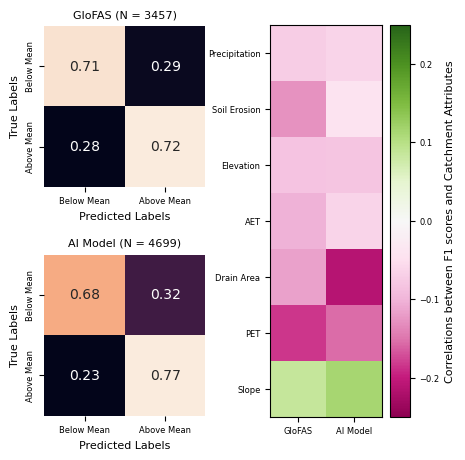

In [13]:
fig, axes = plt.subplots(
    2, 2, 
    figsize=(
            evaluation_utils.NATURE_FIG_SIZES['one_half_column'],
            evaluation_utils.NATURE_FIG_SIZES['one_half_column']
    )
)

gs = axes[0, 0].get_gridspec()
for ax in axes[:, -1]:
    ax.remove()
bigax = fig.add_subplot(gs[:, -1])

# --- GloFAS --------------------------------
regression_data = f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
    lead_time][return_period].dropna().rename(metric)
experiment = metrics_utils.GLOFAS_VARIABLE
bins = None# [-0.1, regression_data.mean(), 1.01]

x, y = skill_prediction_utils.make_predictors(
    x=regression_attributes,
    y=regression_data,
    metric=metric,
    bins=bins
)

y_hat = skill_prediction_utils.train_kfold(
    x, y,
    # classifier=True
    regression=True
)

bins = [-0.1, regression_data.mean(), 1.01]
bin_names = [idx for idx, bin in enumerate(bins[1:])]
y_cat = pd.cut(y, bins=bins, include_lowest=True, labels=bin_names)
y_hat_cat = pd.cut(y_hat, bins=bins, include_lowest=True, labels=bin_names)

print('------------------------------------')
print('------------------------------------')
print(experiment)
print(precision_recall_fscore_support(y_cat, y_hat_cat, average='micro'))
print('------------------------------------')
print('------------------------------------')

ax = axes[0, 0]
cm = confusion_matrix(y_cat, y_hat_cat, normalize='true')
sns.heatmap(cm, annot=True, ax=ax, cbar=False, fmt='.2g')
ax.set_aspect('equal', 'box')
ax.set_title(
    f'{evaluation_utils.EXPERIMENT_NAMES[experiment]} (N = {y.shape[0]})',
    fontsize=evaluation_utils.NATURE_FONT_SIZES['title']
)
ax.set_xlabel(
    'Predicted Labels', 
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label']
)
ax.set_ylabel(
    'True Labels', 
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label']
)
ax.xaxis.set_ticklabels(
    ['Below Mean', 'Above Mean'],
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)
ax.yaxis.set_ticklabels(
    ['Below Mean', 'Above Mean'],
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)


# --- Google Model ----------------------------
regression_data = f1s_by_lead_time['google_1980']['kfold_splits'][
    lead_time][return_period].dropna().rename(metric)
experiment = 'kfold_splits'
bins = None# [-0.1, regression_data.mean(), 1.01]

x, y = skill_prediction_utils.make_predictors(
    x=regression_attributes,
    y=regression_data,
    metric=metric,
    bins=bins
)

y_hat = skill_prediction_utils.train_kfold(
    x, y,
    # classifier=True
    regression=True
)

bins = [-0.1, regression_data.mean(), 1.01]
bin_names = [idx for idx, bin in enumerate(bins[1:])]
y_cat = pd.cut(y, bins=bins, include_lowest=True, labels=bin_names)
y_hat_cat = pd.cut(y_hat, bins=bins, include_lowest=True, labels=bin_names)

print('------------------------------------')
print('------------------------------------')
print(experiment)
print(precision_recall_fscore_support(y_cat, y_hat_cat, average='micro'))
print('------------------------------------')
print('------------------------------------')

ax = axes[1, 0]
cm = confusion_matrix(y_cat, y_hat_cat, normalize='true')
sns.heatmap(cm, annot=True, ax=ax, cbar=False, fmt='.2g')
ax.set_aspect('equal', 'box')
ax.set_title(
    f'{evaluation_utils.EXPERIMENT_NAMES[experiment]} (N = {y.shape[0]})',
    fontsize=evaluation_utils.NATURE_FONT_SIZES['title']
)
ax.set_xlabel(
    'Predicted Labels', 
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label']
)
ax.set_ylabel(
    'True Labels', 
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label']
)
ax.xaxis.set_ticklabels(
    ['Below Mean', 'Above Mean'],
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)
ax.yaxis.set_ticklabels(
    ['Below Mean', 'Above Mean'],
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)

# --- Attribute Correlations -----------------
combined_data = pd.concat([
    f1s_by_lead_time['glofas_1980'][metrics_utils.GLOFAS_VARIABLE][
        lead_time][return_period].dropna().rename(metrics_utils.GLOFAS_VARIABLE),
    f1s_by_lead_time['google_1980']['kfold_splits'][
        lead_time][return_period].dropna().rename('kfold_splits')
], axis=1).dropna()

corr_matrix = pd.concat([regression_attributes, combined_data], axis=1).dropna()
c = corr_matrix.corr()[[metrics_utils.GLOFAS_VARIABLE, 'kfold_splits']].drop(
    [metrics_utils.GLOFAS_VARIABLE, 'kfold_splits'])
cabs = c.abs()

im = bigax.imshow(
    c.loc[top_features, [metrics_utils.GLOFAS_VARIABLE, 'kfold_splits']], 
    cmap='PiYG',
    vmin=-0.25, vmax=0.25,
)
bigax.set_xticks(
    [0,1], 
    ['GloFAS', 'AI Model'],
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)
bigax.set_yticks(
    range(len(top_features)),
    top_features,
    fontsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']
)
cbar = plt.colorbar(im, ax=bigax)
cbar.set_label(
    'Correlations between F1 scores and Catchment Attributes', 
    rotation=90, 
    fontsize=evaluation_utils.NATURE_FONT_SIZES['axis_label']
)
cbar.ax.tick_params(labelsize=evaluation_utils.NATURE_FONT_SIZES['tick_labels']) 

plt.tight_layout()

evaluation_utils.save_figure(data_paths.PREDICATABILITY_CONFUSION_MATRICES_FILENAME)